# 第6回講義 演習

## 課題1. Denoising Autoencoderの実装. また, MNISTを用いて次のことを確認

- reconstruction errorが小さくなっている（学習が進んでいる）
- 重みの可視化（特徴の可視化）

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from tensorflow.examples.tutorials.mnist import input_data

rng = np.random.RandomState(1234)
random_state = 42

### 1. MNISTデータセットの読み込み

In [2]:
mnist = input_data.read_data_sets('MNIST_data/', one_hot=True)
mnist_X, mnist_y = mnist.train.images, mnist.train.labels
train_X, valid_X, train_y, valid_y = train_test_split(mnist_X, mnist_y, test_size=0.1, random_state=random_state)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### 2. Autoencoderの実装

In [3]:
class Autoencoder:
    def __init__(self, vis_dim, hid_dim, function=lambda x: x):
        self.W = tf.Variable(rng.uniform(low=-0.08, high=0.08, size=(vis_dim, hid_dim)).astype('float32'), name='W')
        self.a = tf.Variable(np.zeros(vis_dim).astype('float32'), name='a')
        self.b = tf.Variable(np.zeros(hid_dim).astype('float32'), name='b')
        self.function = function
        self.params = [self.W, self.a, self.b]

    def encode(self, x):
        u = tf.matmul(x, self.W) + self.b
        return self.function(u)

    def decode(self, x):
        u = tf.matmul(x, tf.transpose(self.W)) + self.a
        return self.function(u)

    def f_prop(self, x):
        y = self.encode(x)
        return self.decode(y)

    def reconst_error(self, x, noise):
        tilde_x = x * noise
        reconst_x = self.f_prop(tilde_x)
        error = -tf.reduce_mean(tf.reduce_sum(x * tf.log(reconst_x) + (1. - x) * tf.log(1. - reconst_x), axis=1))
        return error, reconst_x

### 確率的勾配法 (Stochastic Gradient Descent)

In [4]:
def sgd(cost, params, eps=np.float32(0.1)):
    g_params = tf.gradients(cost, params)
    updates = []
    for param, g_param in zip(params, g_params):
        if g_param != None:
            updates.append(param.assign_add(-eps*g_param))
    return updates

### 3. モデルの構築

In [5]:
X = np.copy(train_X)

model = Autoencoder(X.shape[1], 500, tf.nn.sigmoid)

x = tf.placeholder(tf.float32, [None, 784], name='x')
noise = tf.placeholder(tf.float32, [None, 784], name='noise')

cost, reconst_x = model.reconst_error(x, noise)
params = model.params
updates = sgd(cost, params)
train = tf.group(*updates)

In [11]:
rng.binomial(3, 1, 3)

array([3, 3, 3])

### 4. 学習

#### 4.1 Corruption level=0の場合

In [12]:
n_epochs = 10
batch_size = 100
n_batches = X.shape[0]//batch_size

corruption_level = np.float32(0.0)

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    for epoch in range(n_epochs):
        X = shuffle(X, random_state=random_state)
        err_all = []
        for i in range(n_batches):
            start = i * batch_size
            end = start + batch_size

            _noise = rng.binomial(size=X[start:end].shape, n=1, p=1-corruption_level)
            _, err = sess.run([train, cost], feed_dict={x: X[start:end], noise: _noise})
            err_all.append(err)
        print('EPOCH:%d, ERROR:%lf' % (epoch+1, np.mean(err_all)))

    weight_1 = sess.run(tf.transpose(model.W))

EPOCH:1, ERROR:90.805199
EPOCH:2, ERROR:66.593163
EPOCH:3, ERROR:61.505043
EPOCH:4, ERROR:58.992504
EPOCH:5, ERROR:57.510803
EPOCH:6, ERROR:56.539131
EPOCH:7, ERROR:55.850353
EPOCH:8, ERROR:55.332085
EPOCH:9, ERROR:54.924931
EPOCH:10, ERROR:54.595116


#### 4.2 Corruption level=0.3の場合

In [13]:
corruption_level = np.float32(0.3)

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    for epoch in range(n_epochs):
        X = shuffle(X, random_state=random_state)
        err_all = []
        for i in range(n_batches):
            start = i * batch_size
            end = start + batch_size

            _noise = rng.binomial(size=X[start:end].shape, n=1, p=1-corruption_level)
            _, err = sess.run([train, cost], feed_dict={x: X[start:end], noise: _noise})
            err_all.append(err)
        print('EPOCH:%d, ERROR:%lf' % (epoch+1, np.mean(err_all)))

    weight_2 = sess.run(tf.transpose(model.W))

EPOCH:1, ERROR:103.980965
EPOCH:2, ERROR:81.162086
EPOCH:3, ERROR:77.295876
EPOCH:4, ERROR:75.249763
EPOCH:5, ERROR:73.954262
EPOCH:6, ERROR:72.962975
EPOCH:7, ERROR:72.106125
EPOCH:8, ERROR:71.394112
EPOCH:9, ERROR:70.736351
EPOCH:10, ERROR:70.182480


### 5. 重みの可視化

- corruption levelの違いによる重みの違いを確認

In [18]:
print(weight_1.shape)

(500, 784)


#### 5.1 Corruption level=0の場合

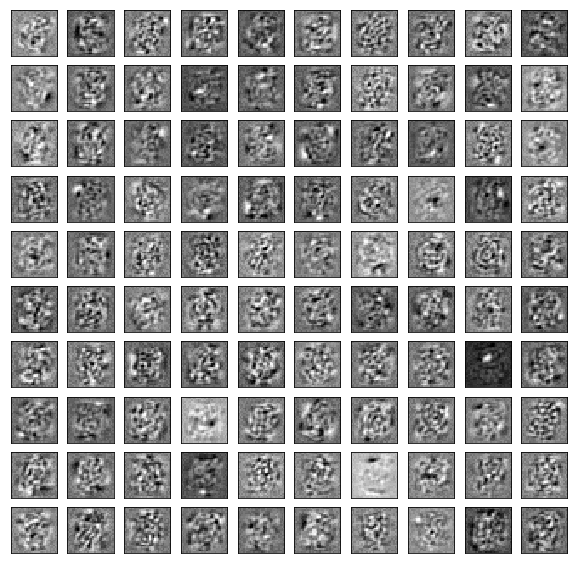

In [14]:
fig = plt.figure(figsize=(10, 10))
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(weight_1[i].reshape((28, 28)), cmap='gray')

#### 5.2 Corruption level=0.3の場合

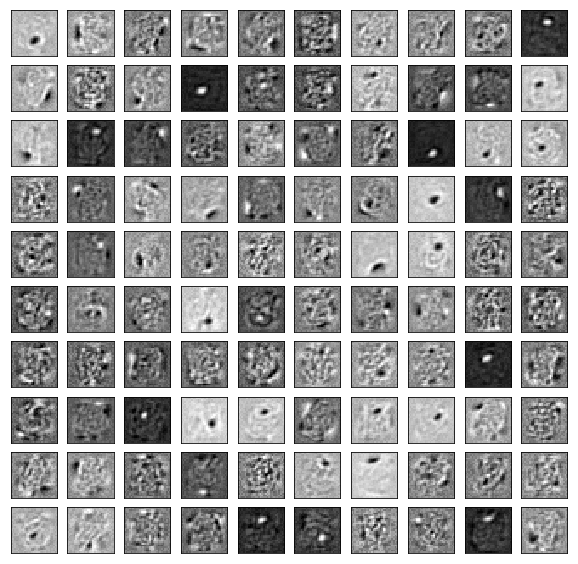

In [15]:
fig = plt.figure(figsize=(10, 10))
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(weight_2[i].reshape((28, 28)), cmap='gray')

## 課題2. Stacked Denoising Autoencoder (SdA) の実装

### 1. 各クラスの実装

#### autoencoder

In [19]:
class Autoencoder:
    def __init__(self, vis_dim, hid_dim, W, function=lambda x: x):
        self.W = W
        self.a = tf.Variable(np.zeros(vis_dim).astype('float32'), name='a')
        self.b = tf.Variable(np.zeros(hid_dim).astype('float32'), name='b')
        self.function = function
        self.params = [self.W, self.a, self.b]

    def encode(self, x):
        u = tf.matmul(x, self.W) + self.b
        return self.function(u)
    
    def decode(self, x):
        u = tf.matmul(x, tf.transpose(self.W)) + self.a
        return self.function(u)

    def f_prop(self, x):
        y = self.encode(x)
        return self.decode(y)

    def reconst_error(self, x, noise):
        tilde_x = x * noise
        reconst_x = self.f_prop(tilde_x)
        error = -tf.reduce_mean(tf.reduce_sum(x * tf.log(reconst_x) + (1. - x) * tf.log(1. - reconst_x), axis=1))
        return error, reconst_x

#### 全結合層

In [20]:
class Dense:
    def __init__(self, in_dim, out_dim, function):
        self.W = tf.Variable(rng.uniform(low=-0.08, high=0.08, size=(in_dim, out_dim)).astype('float32'), name='W')
        self.b = tf.Variable(np.zeros([out_dim]).astype('float32'))
        self.function = function
        self.params = [self.W, self.b]
        
        self.ae = Autoencoder(in_dim, out_dim, self.W, self.function)

    def f_prop(self, x):
        u = tf.matmul(x, self.W) + self.b
        self.z = self.function(u)
        return self.z

    def pretrain(self, x, noise):
        cost, reconst_x = self.ae.reconst_error(x, noise)
        return cost, reconst_x

### 2. ネットワークの定義

In [21]:
layers = [
    Dense(784, 500, tf.nn.sigmoid),
    Dense(500, 500, tf.nn.sigmoid),
    Dense(500, 10, tf.nn.softmax)
]

### 3. 事前学習 (Pre-training)

In [22]:
X = np.copy(train_X)

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
for l, layer in enumerate(layers[:-1]):
    corruption_level = np.float(0.3)
    batch_size = 100
    n_batches = X.shape[0] // batch_size
    n_epochs = 10

    x = tf.placeholder(tf.float32)
    noise = tf.placeholder(tf.float32)
    
    cost, reconst_x = layer.pretrain(x, noise)
    params = layer.params
    train = sgd(cost, params)
    encode = layer.f_prop(x)
    
    for epoch in range(n_epochs):
        X = shuffle(X, random_state=random_state)
        err_all = []
        for i in range(n_batches):
            start = i * batch_size
            end = start + batch_size

            _noise = rng.binomial(size=X[start:end].shape, n=1, p=1-corruption_level)
            _, err = sess.run([train, cost], feed_dict={x: X[start:end], noise: _noise})
            err_all.append(err)
        print('Pretraining:: layer: %d, Epoch: %d, Error: %lf' % (l+1, epoch+1, np.mean(err)))
    X = sess.run(encode, feed_dict={x: X})

Pretraining:: layer: 1, Epoch: 1, Error: 86.720230
Pretraining:: layer: 1, Epoch: 2, Error: 83.853661
Pretraining:: layer: 1, Epoch: 3, Error: 75.455368
Pretraining:: layer: 1, Epoch: 4, Error: 76.259811
Pretraining:: layer: 1, Epoch: 5, Error: 74.690994
Pretraining:: layer: 1, Epoch: 6, Error: 74.224846
Pretraining:: layer: 1, Epoch: 7, Error: 71.753151
Pretraining:: layer: 1, Epoch: 8, Error: 71.358177
Pretraining:: layer: 1, Epoch: 9, Error: 70.727379
Pretraining:: layer: 1, Epoch: 10, Error: 70.806862
Pretraining:: layer: 2, Epoch: 1, Error: 140.538498
Pretraining:: layer: 2, Epoch: 2, Error: 145.091614
Pretraining:: layer: 2, Epoch: 3, Error: 139.643463
Pretraining:: layer: 2, Epoch: 4, Error: 144.705734
Pretraining:: layer: 2, Epoch: 5, Error: 137.949432
Pretraining:: layer: 2, Epoch: 6, Error: 139.803116
Pretraining:: layer: 2, Epoch: 7, Error: 132.398270
Pretraining:: layer: 2, Epoch: 8, Error: 134.258362
Pretraining:: layer: 2, Epoch: 9, Error: 134.852951
Pretraining:: layer: 

### 4. 計算グラフ構築 & パラメータの更新設定

In [23]:
x = tf.placeholder(tf.float32, [None, 784])
t = tf.placeholder(tf.float32, [None, 10])

def f_props(layers, x):
    params = []
    for layer in layers:
        x = layer.f_prop(x)
        # これextendかな?
        params += layer.params
    return x, params

y, params = f_props(layers, x)

cost = -tf.reduce_mean(tf.reduce_sum(t * tf.log(y), 1))
updates = sgd(cost, params)

train = tf.group(*updates)
valid = tf.argmax(y, 1)

### 4. 学習 (Fine-tuning)

In [24]:
n_epochs = 10
batch_size = 100
n_batches = train_X.shape[0] // batch_size

for epoch in range(n_epochs):
    train_X, train_y = shuffle(train_X, train_y, random_state=random_state)
    for i in range(n_batches):
        start = i * batch_size
        end = start + batch_size
        sess.run(train, feed_dict={x: train_X[start:end], t: train_y[start:end]})
    pred_y, valid_cost = sess.run([valid, cost], feed_dict={x: valid_X, t: valid_y})
    print('EPOCH: %i, Validation cost: %.3f Validation F1: %.3f' % (epoch + 1, valid_cost, f1_score(np.argmax(valid_y, 1).astype('int32'), pred_y, average='macro')))

EPOCH: 1, Validation cost: 0.295 Validation F1: 0.917
EPOCH: 2, Validation cost: 0.242 Validation F1: 0.931
EPOCH: 3, Validation cost: 0.215 Validation F1: 0.937
EPOCH: 4, Validation cost: 0.196 Validation F1: 0.943
EPOCH: 5, Validation cost: 0.184 Validation F1: 0.947
EPOCH: 6, Validation cost: 0.178 Validation F1: 0.948
EPOCH: 7, Validation cost: 0.167 Validation F1: 0.951
EPOCH: 8, Validation cost: 0.160 Validation F1: 0.954
EPOCH: 9, Validation cost: 0.153 Validation F1: 0.956
EPOCH: 10, Validation cost: 0.148 Validation F1: 0.957


In [25]:
sess.close()